<a href="https://colab.research.google.com/github/Gdkmak/analytics/blob/master/Hypothesis_Testing_And_Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicitive analysis of LA Payroll Data 

The data is taken from lacity.org [website](https://controllerdata.lacity.org/Payroll/City-Employee-Payroll/pazn-qyym). It has payroll information for all Los Angeles City Employees including the City's three proprietary departments: Water and Power, Airports and Harbor. The dataset containes information from 2013 year till 2018. 



We will do **Hypothesis testing** to check if there is a difference in the payrolll between two years 2015 and 2016:<br>
1. Z-test scores<br>
2. ANOVA<br>

For **predictive analysis** I will use **Machine learning** tecniques such as:
1. Linear Regression<br>
2. Random Forests<br>

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [15]:
dataset = pd.read_csv("City_Employee_Payroll.csv")
dataset.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Row ID,Year,Department Title,Payroll Department,Record Number,Job Class Title,Employment Type,Hourly or Event Rate,Projected Annual Salary,Q1 Payments,Q2 Payments,Q3 Payments,Q4 Payments,Payments Over Base Pay,% Over Base Pay,Total Payments,Base Pay,Permanent Bonus Pay,Longevity Bonus Pay,Temporary Bonus Pay,Lump Sum Pay,Overtime Pay,Other Pay & Adjustments,Other Pay (Payroll Explorer),MOU,MOU Title,FMS Department,Job Class,Pay Grade,Average Health Cost,Average Dental Cost,Average Basic Life,Average Benefit Cost,Benefits Plan,Job Class Link
0,3-1000027830ctFu,2013,Police (LAPD),4301.0,1000027830,Police Detective II,Full Time,53.16,110998.08,24931.20,29181.61,26545.80,29605.30,4499.12,0.0,110263.91,105764.79,3174.12,0.00,1325.0,0.00,0.00,0.00,4499.12,24,POLICE OFFICERS UNIT,70,2223,2,11651.40,898.08,191.04,12740.52,Police,http://per.lacity.org/perspecs/2223.pdf
1,3-1000155488ctFu,2013,Police (LAPD),4302.0,1000155488,Clerk Typist,Full Time,23.77,49623.67,11343.96,13212.37,11508.36,13442.53,1844.82,0.0,49507.22,47662.40,0.00,1310.82,0.0,0.00,0.00,534.00,1844.82,3,CLERICAL UNIT,70,1358,0,10710.24,405.24,11.40,11126.88,City,http://per.lacity.org/perspecs/1358.pdf
2,3-1000194958ctFu,2013,Police (LAPD),4301.0,1000194958,Police Sergeant I,Full Time,60.80,126950.40,24184.00,28327.20,28744.20,33224.88,13192.43,0.0,114480.28,101287.85,7363.95,0.00,1205.0,2133.18,4424.32,-1934.02,8768.11,24,POLICE OFFICERS UNIT,70,2227,1,11651.40,898.08,191.04,12740.52,Police,http://per.lacity.org/perspecs/2227.pdf
3,3-1000198958ctFu,2013,Zoo,8701.0,1000198958,Light Equipment Operator,Full Time,30.23,63126.77,15319.59,17762.14,15601.85,18233.32,5924.08,0.0,66916.90,60992.82,3446.79,1677.29,800.0,0.00,0.00,0.00,5924.08,4,EQUIP.OPER. & LABOR,87,3523,0,10710.24,405.24,11.40,11126.88,City,http://per.lacity.org/perspecs/3523.pdf
4,3-1000232317ctFu,2013,Police (LAPD),4301.0,1000232317,Police Lieutenant I,Full Time,60.98,127326.24,29391.20,36591.20,32904.81,37234.03,18034.53,0.0,136121.24,118086.71,7086.67,0.00,1325.0,0.00,9839.33,-216.47,8195.20,24,POLICE OFFICERS UNIT,70,2232,1,11651.40,898.08,191.04,12740.52,Police,http://per.lacity.org/perspecs/2232.pdf


## Data Cleaning: 
Data needs to be clean; a few steps such as. I will be focusing on pay valriables. 

1. delete null pata points from some variables
2. delete rows with zeros 
3. replace $ sign with nothing
4. rename some columns to makes it easy to call them



In [17]:
# delete null values in payroll department

df = dataset[pd.notnull(dataset['Payroll Department'])]
df = dataset[pd.notnull(dataset['Base Pay'])]


# change some columns' names

df.rename(columns={'Projected Annual Salary' : 'Annual_sal'}, inplace = True)
df.rename(columns={'Job Class Title' : 'Job_title'}, inplace = True)
df.rename(columns={'Base Pay' : 'Base_Pay'}, inplace = True)


# delete zeros from Annual salary and Base pay variables

df = df[df.Annual_sal != 0]  
df = df[df.Base_Pay != 0]
df.Annual_sal = df.Annual_sal.astype(float)
df.Base_Pay = df.Base_Pay.astype(float)

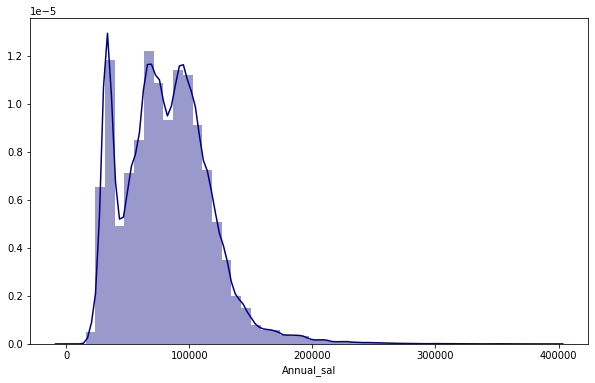

In [18]:
plt.figure(figsize = (10,6))
sns.distplot(df.Annual_sal,color = 'navy')

In [19]:
df.Year.unique()

array([2013, 2014, 2015, 2017, 2016, 2018])

The dataset has payroll data for years between 2013 and 2018. I will take two populations from the existing dataset, one represnts the year of 2013 and another one for 2014.

In [24]:
df_14 = df[df.Year == 2014]
df_15 = df[df.Year == 2015]
df_16 = df[df.Year == 2016]
df_17 = df[df.Year == 2017]
df_18 = df[df.Year == 2018]

Calculating the Population Parameters which are the mean and the standard deviation.

In [21]:
# mean and std from the smaple in 2015 and 2106  

mean_2015 = df_15['Annual_sal'].mean()
std_2015 = statistics.stdev(df_15.Annual_sal)
mean_2016 = df_16['Annual_sal'].mean()
std_2016 = statistics.stdev(df_16.Annual_sal)

print(f"Population Mean 2015: {mean_2015}")
print(f"Population Standard Deviation 2015: {std_2015}")
print(f"Population Mean 2016: {mean_2016}")
print(f"Population Standard Deviation 2016: {std_2016}")

Population Mean 2015: 79326.04829235564
Population Standard Deviation 2015: 33892.88647304113
Population Mean 2016: 81644.61963817796
Population Standard Deviation 2016: 35033.057110714675


## Hypothesis Testing

### z- test scores: 

A z-test for two means is a hypothesis test that attempts to make a claim about the population means `(μ1\mu_1μ1​ and μ2\mu_2μ2​)`. More specifically, we are interested in assessing whether or not it is reasonable to claim that the two population means the population means `μ\muμ1` and `μ\muμ2` are equal, based on the information provided by the samples. The test has two non-overlapping hypotheses, the null and the alternative hypothesis. <br>

`H0`: Pay does not increase in 2016 <br>
`Ha`: There is an increase in 2016

In [22]:
# Confidence Level 95 %  for one right sided normal distribution
# zscore_critical = 1.65 
# significance level = .05
# Calculate the test statistics 
z_test_score = ((mean_2015 - mean_2016)) /  ( math.sqrt(std_2015**2 /df_15.shape[0]) + math.sqrt(std_2016**2 / df_16.shape[0]) ) 
print(z_test_score)

-8.19947277227674


Conclusion: As the test statistics fall into the fail to reject region and we failed to reject the null hypothesis. The p-value from z-score is : 0.38209 calculated [here](https://www.statology.org/z-score-to-p-value-calculator/) and that can be concluded that there is no significant evidence that the annual salaries has increased in 2016. 

### F Distribution and one-way ANOVA

ANOVA is used to determine whether there are any statistically significant differences between the means of three or more independent (unrelated) groups. It is similar to applying t-tests over multiple sample. I will do the test on the electricians's base pay during the three years 2014, 2015, 2016. 

`H0`: The group means didn't change and there is no difference in base pay for electricion. <br>
`Ha`: There are at least two group means that are statistically significantly different from each other.


In [25]:
payroll_2014_elec = df_14[df_14.Job_title == 'Electrician']
payroll_2015_elec = df_15[df_15.Job_title == 'Electrician']
payroll_2016_elec = df_16[df_16.Job_title == 'Electrician']

sample_elec_2014 = payroll_2014_elec.sample(frac=0.45)
sample_elec_mean_2014 = sample_elec_2014['Base_Pay'].mean()
print("Sample Mean 2014 "+str(sample_elec_mean_2014))

sample_elec_2015 = payroll_2015_elec.sample(frac=0.38)
sample_elec_mean_2015 = sample_elec_2015['Base_Pay'].mean()
print("Sample Mean 2015 "+str(sample_elec_mean_2015))

sample_elec_2016 = payroll_2016_elec.sample(frac=0.25)
sample_elec_mean_2016 = sample_elec_2016['Base_Pay'].mean()
print("Sample Mean 2016 "+str(sample_elec_mean_2016))

# Creating the Samples of the base pays over three years
sam_1 = sample_elec_2014.Base_Pay
sam_2 = sample_elec_2015.Base_Pay
sam_3 = sample_elec_2016.Base_Pay


Sample Mean 2014 76423.74942857143
Sample Mean 2015 67595.31333333334
Sample Mean 2016 76505.12857142858


**Calculating the test statistics**

In [26]:
f, p = stats.f_oneway(sam_1, sam_2, sam_3 )
print ('F value:', f)
print ('P value:', p, '\n')

F value: 1.5854338332809312
P value: 0.21078743805678543 



P value is very small, therefore we reject the null hypothesis. 

## Predictive Analysis using Machine Learning: 

### Random Forest: 

It has an ensemble approach where it generates many randomized decision trees to predict output, numerical output in this case. We will predict the salaries according to their job titles.

In [27]:
# Transform the qualitative data into vectors
vect = TfidfVectorizer(stop_words = 'english')
X = vect.fit_transform(df.Job_title)
y = df.Annual_sal

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

# fit the model
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [28]:
print('R^2 score training set: {}'.format(r2_score(y_train, pred_train)))
print('R^" score test set: {}'.format(r2_score(y_test, pred_test)))

R^2 score training set: 0.9323329532516339
R^" score test set: 0.9323736535563492


Let's check the accuracy in a more visual way.

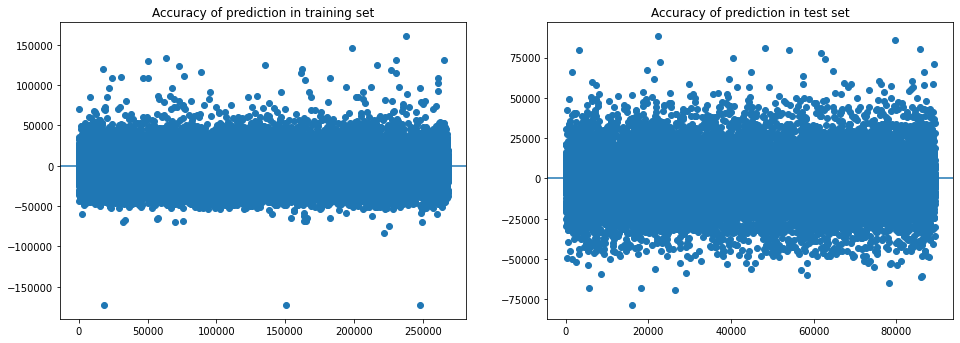

In [29]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot([x for x in range(len(pred_train))], y_train - pred_train, 'o')
ax1.axhline(0)
ax1.title.set_text('Accuracy of prediction in training set')

ax2.plot([x for x in range(len(pred_test))], y_test - pred_test,'o')
ax2.axhline(0)
ax2.title.set_text('Accuracy of prediction in test set')

### Linear Regression:

In [30]:
# Selecting the features and creating train test split
X = df[['Annual_sal','Q1 Payments','Q2 Payments','Q3 Payments','Q4 Payments']].copy()
y = df["Average Benefit Cost"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [31]:
# train the model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
ranked_suburbs = coeff_df.sort_values("Coefficient", ascending = False)
print(f"Model intercept: {lm.intercept_}\n")
print(ranked_suburbs)

Model intercept: 4415.524171191288

             Coefficient
Q1 Payments     0.134087
Q4 Payments     0.113864
Annual_sal      0.022158
Q3 Payments     0.010595
Q2 Payments    -0.009730


As you notice from the coefficient, there are no good correlation between these chosen variables. So i don't anticipate a good prediction. 

In [33]:
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)
print('R^2 score Training set: {}'.format(r2_score(y_train, pred_train)))
print('R^2 score Test set: {}'.format(r2_score(y_test, pred_test)))

R^2 score Training set: 0.4290767692430949
R^2 score Test set: 0.42693932754910646


As we accpected, there is a high difference between the observed data points and the fitted values. 